last edited on November 12 by Claire Valva
# Endless seasons for 40.5N spectral analysis

This notebook uses fft coefficient values (averaged for each season) to then create an arbitrarily long wave (ie. an endless summer etc) for later analysis.

In [1]:
#import packages
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq, fftshift, ifftshift
import scipy
import matplotlib.pyplot as plt
from math import pi
import matplotlib.ticker as tck
import datetime
import pickle
from functions_forspectralanalysis import * #just in case I need it?
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.fourier import fourier_gaussian
from seaborn import cubehelix_palette

/home/clairev/python-climate-data-processing/submission_from_claire/40.5N-processing/functions_forspectralanalysis.py:84: RuntimeWarning: divide by zero encountered in true_divide
  zonal_spacing = 1/zonal_spacing


In [2]:
#load 2d transform from last time
file_Name = "transform_2d_oct2018"
file_pickle = open(file_Name,'rb') 
loaded_pickle = pickle.load(file_pickle)

In [3]:
d2_trans, seasons, d2_averages = loaded_pickle

## write function to extend season length and test

In [4]:
to_test = d2_trans[5]

In [5]:
#get longer array
wantedl = 90*4*100*2
zero_array = np.zeros(shape = 100, dtype = "complex128")
appended_zeros = [np.concatenate((zero_array, fftshift(entry), zero_array)) for entry in to_test]

#make up for changed dimensions
newdim = len(appended_zeros[5])
olddim = len(d2_trans[4][4])
mult = newdim/olddim

forifft = np.multiply(mult, appended_zeros)
forifft = [fftshift(entry) for entry in forifft]

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


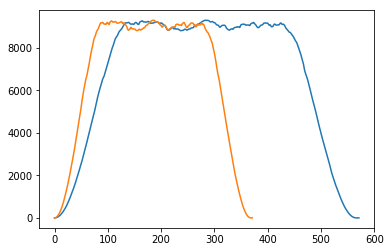

In [6]:
#try to see if that worked?
tested = np.fft.ifft2(forifft)
old = np.fft.ifft2(d2_trans[5])

plt.clf()
plt.plot(tested[12])
plt.plot(old[12])
#plt.plot(tested[50])
plt.show()

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


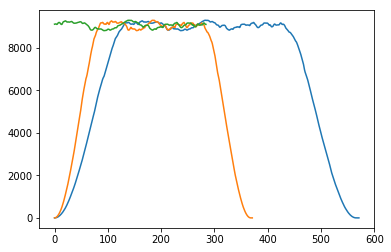

In [7]:
#now test that should chop off the first and second half
total_len = len(tested[12])
sixth = total_len/4
end = total_len - sixth
adjusted_tested = [[entry[i] for i in range(len(entry)) if i > sixth and i < end] 
                   for entry in tested]

#now see it again
plt.clf()
plt.plot(tested[12])
plt.plot(old[12])
plt.plot(adjusted_tested[12])
#plt.plot(tested[50])
plt.show()

In [8]:
##write that all up into a neat function


def ext_ifft(length, input_array):
    #add the zeros onto each end
    zero_array = np.zeros(shape = length, dtype = "complex128")
    appended_zeros = [np.concatenate((zero_array, fftshift(entry), zero_array)) 
                      for entry in input_array]
    
    #make up for the formulat multiplying for array length
    newdim = len(appended_zeros[5])
    olddim = len(input_array[0])
    mult = newdim/olddim
    forifft = np.multiply(mult,appended_zeros)
    forifft = [fftshift(entry) for entry in forifft]
    
    #apply ifft
    iarr = np.fft.ifft2(forifft)
    
    #cut off the windowed parts for later plotting
    total_len = len(iarr[12])
    fourth = int(total_len/4)
    end = int(total_len - fourth)
    
    adjusted_tested = [entry[fourth:end] for entry in iarr]
    
    return adjusted_tested

/home/clairev/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


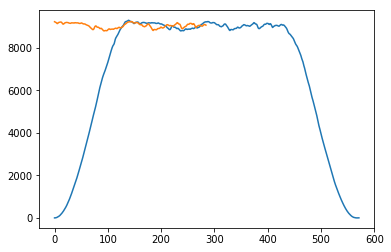

In [9]:
#test the function vs. what was done before
func_test = ext_ifft(length = wantedl, input_array = to_test)

#did it woork.. it woooorked
plt.clf()
plt.plot(tested[15])
plt.plot(adjusted_tested[15])
plt.show()

## Apply extended simulation to seasonal averages

In [10]:
#apply ifft
extended_seasons = np.real([ext_ifft(length=wantedl, input_array = entry) 
                            for entry in d2_averages])


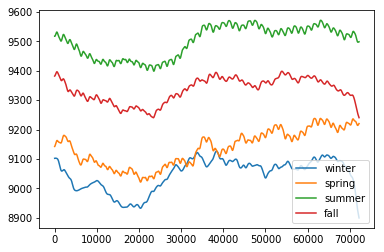

In [11]:
#compare to see if difference in geopotential height stayed
plt.clf()
plt.plot(extended_seasons[0][13], label = seasons[0])
plt.plot(extended_seasons[1][13], label = seasons[1])
plt.plot(extended_seasons[2][13], label = seasons[2])
plt.plot(extended_seasons[3][13], label = seasons[3])
plt.legend()    
plt.show()

In [12]:
#get mean of each season
mean_seasons = [np.average(entry) for entry in extended_seasons]

### sort the longitudes into buckets

In [13]:
#set lists of longitude sections as strings for labeling
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

In [14]:
def lon_sort(lon):
    #define function to sort into longitude sections
    clon_1 = lon >= 50 and lon <= 140
    clon_2 = lon <= 50 or lon >= 320
    clon_3 = lon >= 230 and lon <= 320
    clon_4 = lon >= 140 and lon <= 230

    if clon_1 == True:
        return(1)
    elif clon_2 == True:
        return(2)
    elif clon_3 == True:
        return(3)
    elif clon_4 == True:
        return(4)
    else:
        return("lon sorting error")

In [15]:
#get beginning and end of each index
lon_index_sort = [[i for i in range(240) if lon_sort(i*1.5) == j + 1] for j in range(4)]
beginning_lons = [entry[0] for entry in lon_index_sort]
end_lons = [entry[len(entry) - 1] for entry in lon_index_sort]

#now slice up the results
#note that this will be heirarchy of season > lon_section
lon_sectioned = [[np.array(entry[beginning_lons[j]:end_lons[j]]) for j in range(4)]
                       for entry in np.array(extended_seasons)]
mean_lons = [[np.average(entry) for entry in season] for season in lon_sectioned]

## Make histograms

In [16]:
flatten = lambda l: [item for sublist in l for item in sublist]

<Figure size 432x288 with 0 Axes>

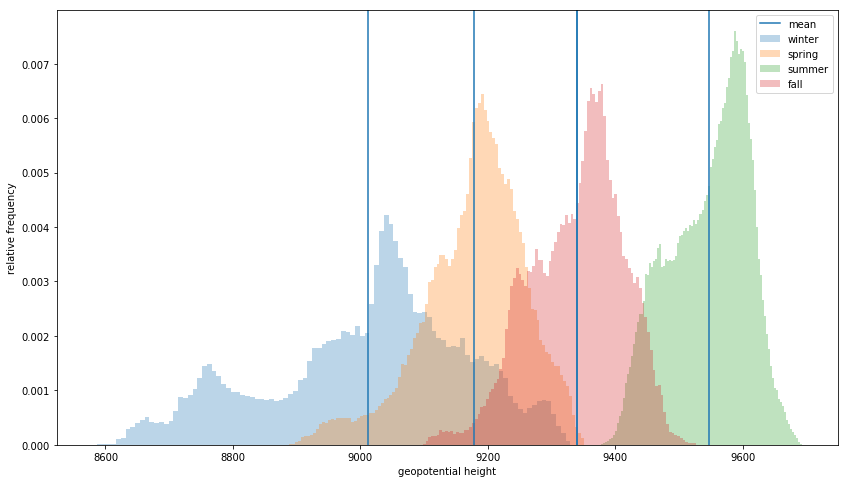

In [17]:
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    plt.hist(flatten(extended_seasons[i]), label = seasons[i], 
             bins = 100, density = True, alpha = 0.3)
    plt.axvline(mean_seasons[i])
plt.xlabel("geopotential height")
plt.axvline(mean_seasons[i], label = "mean")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

### also do for longitude sections

In [18]:
def hist_plot(i):
    to_section = lon_sectioned[i]
    flat_season = flatten(extended_seasons[i])

    minx = np.min(flat_season)
    maxx = np.max(flat_season)
    
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title("geopotential height for extended " + seasons[i])
    plt.hist(flat_season, 
             bins = 100, density = True)
    plt.axvline(mean_seasons[i])
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.show()
    
    


    for j in range(4):
        plt.clf()
        plt.figure(figsize=(8,8))
        plt.hist(flatten(to_section[j]), bins = 100, 
                 density = True,
                 label = lon_sections[j])
        plt.legend()
        plt.axvline(mean_lons[i][j])
        plt.xlim(xmin = minx, xmax = maxx)
        plt.xlabel('geopotential height')
        plt.ylabel('relative frequency')
        plt.show()

<Figure size 432x288 with 0 Axes>

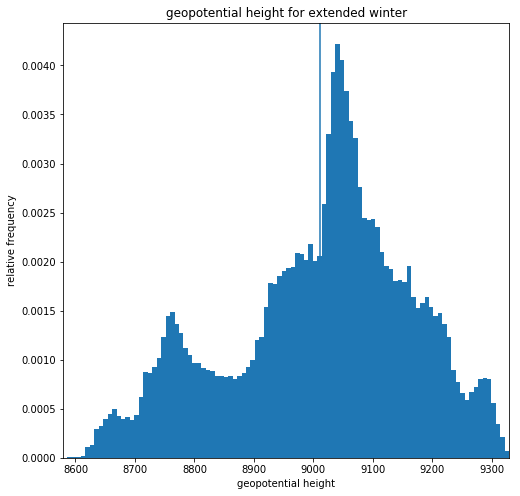

<Figure size 432x288 with 0 Axes>

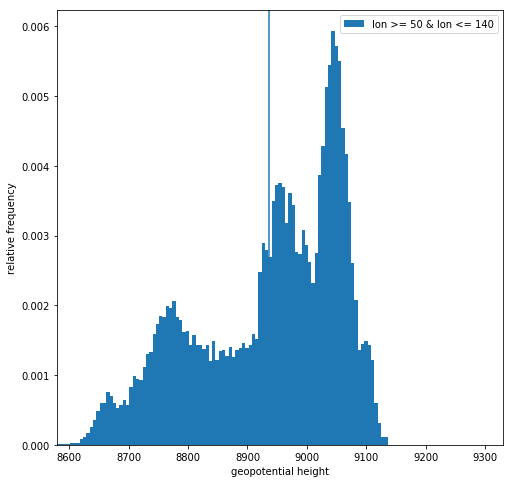

<Figure size 432x288 with 0 Axes>

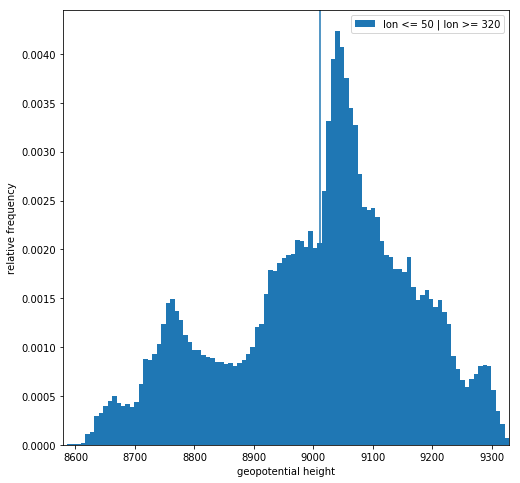

<Figure size 432x288 with 0 Axes>

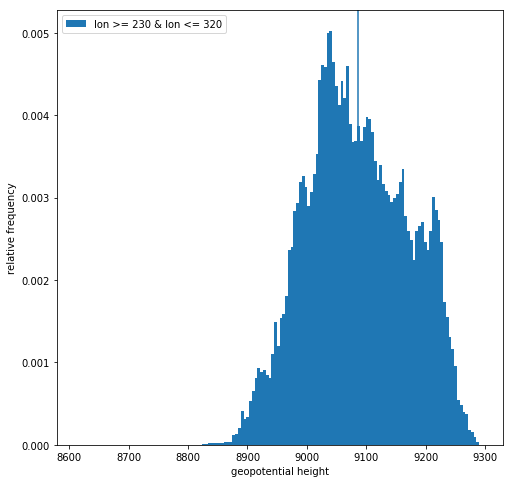

<Figure size 432x288 with 0 Axes>

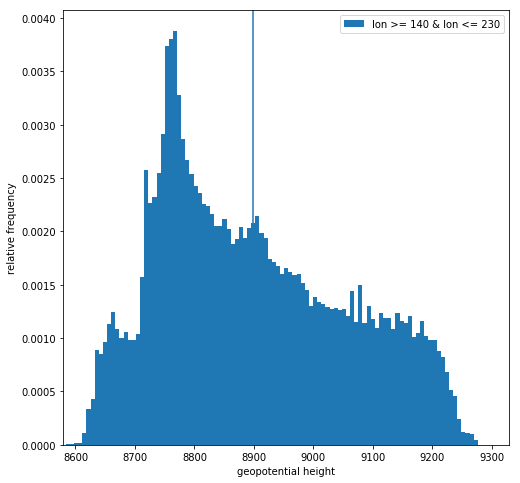

In [19]:
hist_plot(0)

<Figure size 432x288 with 0 Axes>

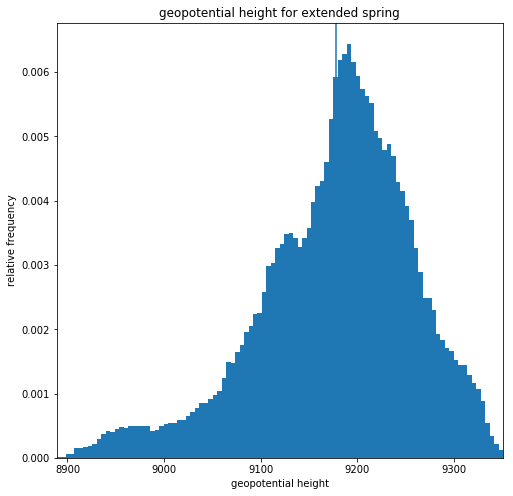

<Figure size 432x288 with 0 Axes>

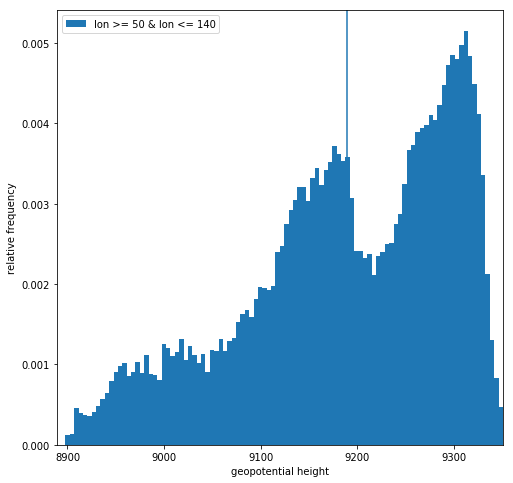

<Figure size 432x288 with 0 Axes>

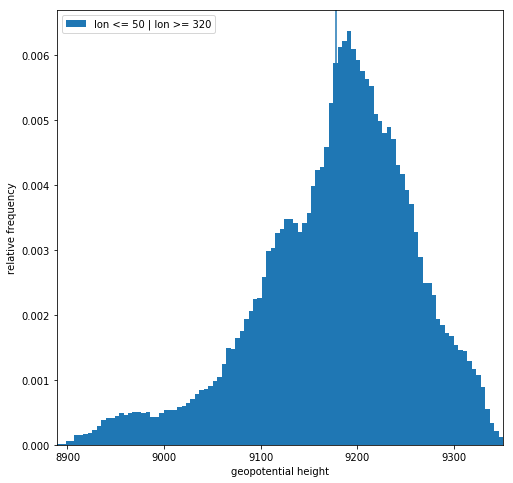

<Figure size 432x288 with 0 Axes>

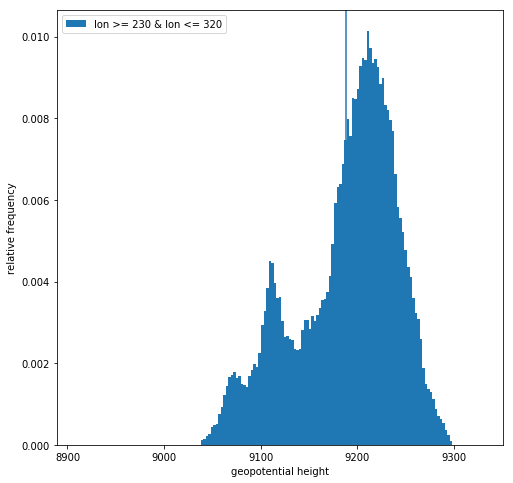

<Figure size 432x288 with 0 Axes>

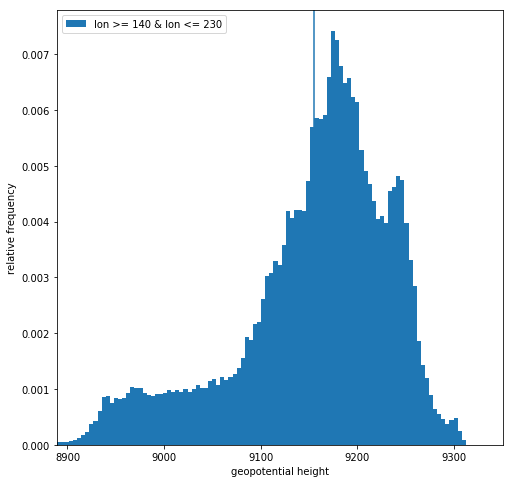

In [20]:
hist_plot(1)

<Figure size 432x288 with 0 Axes>

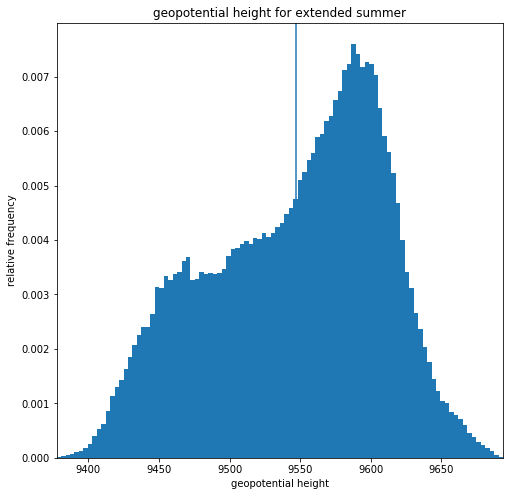

<Figure size 432x288 with 0 Axes>

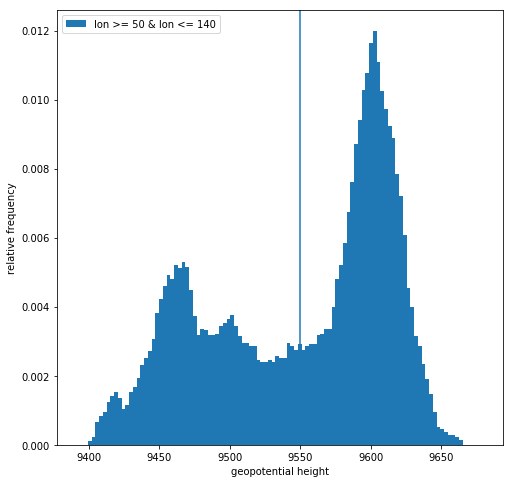

<Figure size 432x288 with 0 Axes>

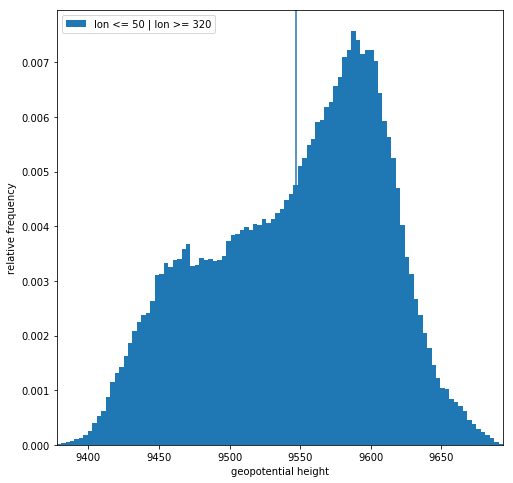

<Figure size 432x288 with 0 Axes>

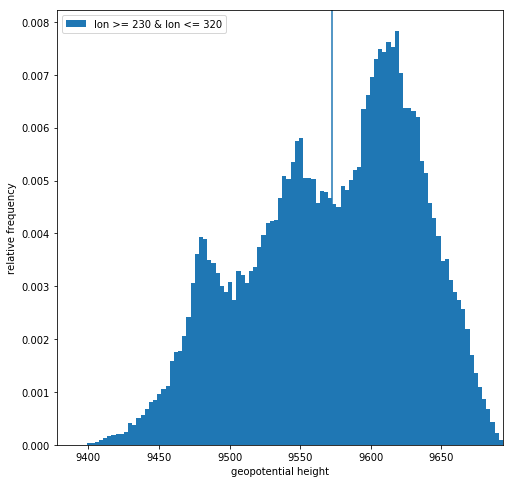

<Figure size 432x288 with 0 Axes>

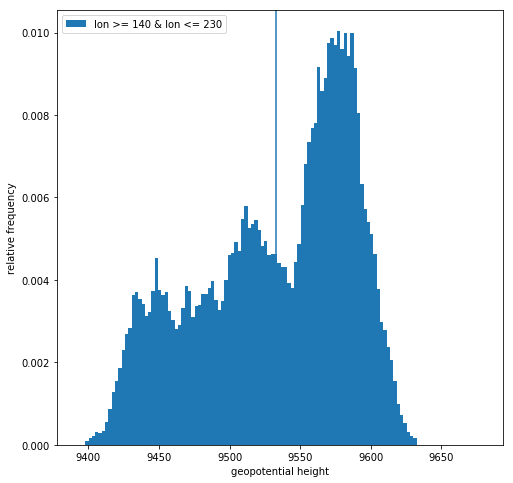

In [21]:
hist_plot(2)

<Figure size 432x288 with 0 Axes>

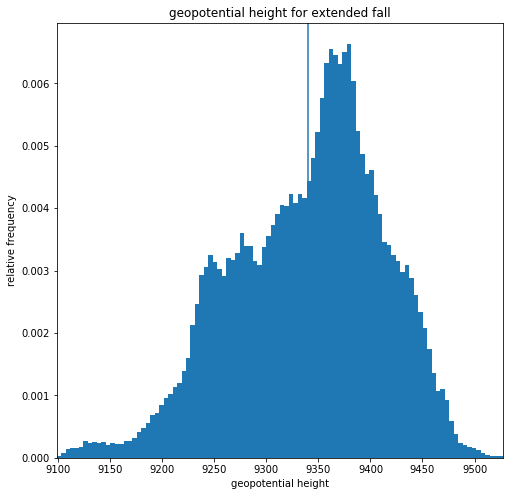

<Figure size 432x288 with 0 Axes>

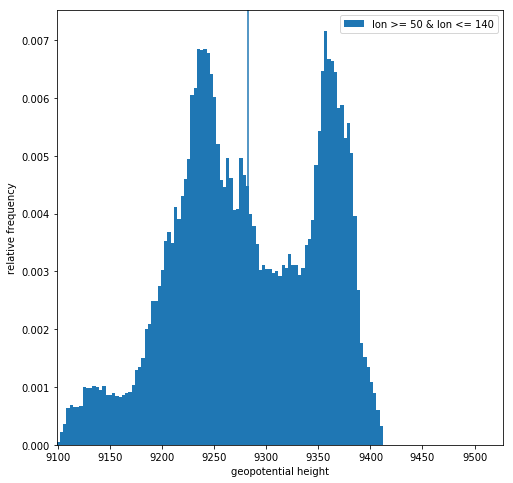

<Figure size 432x288 with 0 Axes>

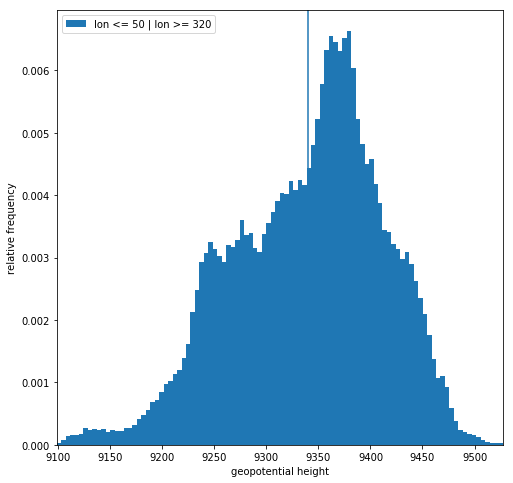

<Figure size 432x288 with 0 Axes>

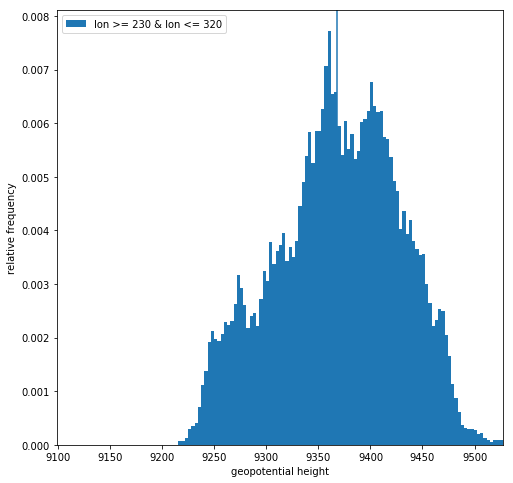

<Figure size 432x288 with 0 Axes>

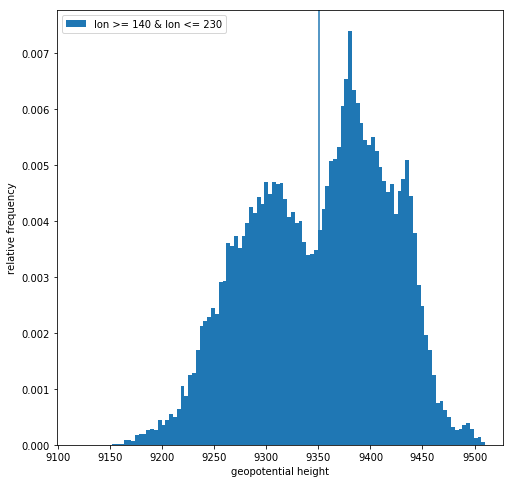

In [22]:
hist_plot(3)

## compare to original histograms

In [23]:
avg4_df = pd.read_pickle('avg4_df.pickle')
geopot_df = pd.read_pickle('geopot_df.pickle')

In [24]:
#drop the duplicates of the imported dataframes
day_df = geopot_df.drop_duplicates(subset=['dayavg'], keep='first', inplace=False)
label_list = ["geopotential", "climatological-mean geopotential"]

In [25]:
#set lists of longitude sections
lon_1 = 'lon >= 50 & lon <= 140'
lon_2 = 'lon <= 50 | lon >= 320'
lon_3 = 'lon >= 230 & lon <= 320'
lon_4 = 'lon >= 140 & lon <= 230'

lon_sections = [lon_1, lon_2, lon_3, lon_4]

In [26]:
def compare_plot(i):
    season = seasons[i]
    #get from simmed data
    to_section = lon_sectioned[i]
    flat_season = flatten(extended_seasons[i])
    
    #get from orig data
    plot_df = day_df[day_df["season"] == season]

    minx = np.min(plot_df['geofrom_climmonth'])
    maxx = np.max(plot_df['geofrom_climmonth'])
    
    plt.clf()
    plt.figure(figsize=(8,8))

    plt.title("geopotential height for extended " + seasons[i])
    plt.hist(flat_season, 
             bins = 100, density = True, alpha = 0.5, label = "simulated")
    plt.hist(plot_df['geofrom_climmonth'], bins = 60, alpha = .5, density = True, label = "original")
    plt.axvline(mean_seasons[i])
    plt.axvline(plot_df['geofrom_climmonth'].mean(), color='orange')
    plt.xlim(xmin = minx, xmax = maxx)
    plt.xlabel('geopotential height')
    plt.ylabel('relative frequency')
    plt.legend()
    plt.show()
    
    


    for j in range(4):
        
        #get the correct original dataframe
        section_df = plot_df.query(lon_sections[j])
        
        plt.clf()
        plt.figure(figsize=(8,8))
        plt.hist(flatten(to_section[j]), bins = 100, 
                 density = True, alpha = 0.5,
                 label = "simulated")
        plt.hist(section_df['geofrom_climmonth'], bins = 60, alpha = .5,
                density = True, label = "original")
        plt.axvline(mean_lons[i][j])
        plt.axvline(section_df['geofrom_climmonth'].mean(), color='orange')
        plt.xlim(xmin = minx, xmax = maxx)
        plt.legend()
        plt.xlabel('geopotential height')
        plt.ylabel('relative frequency')
        plt.show()

<Figure size 432x288 with 0 Axes>

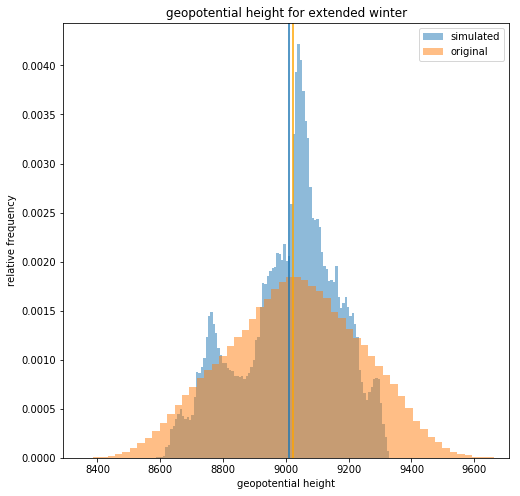

<Figure size 432x288 with 0 Axes>

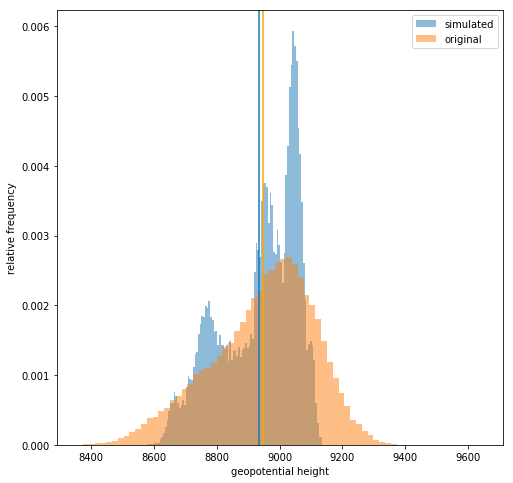

<Figure size 432x288 with 0 Axes>

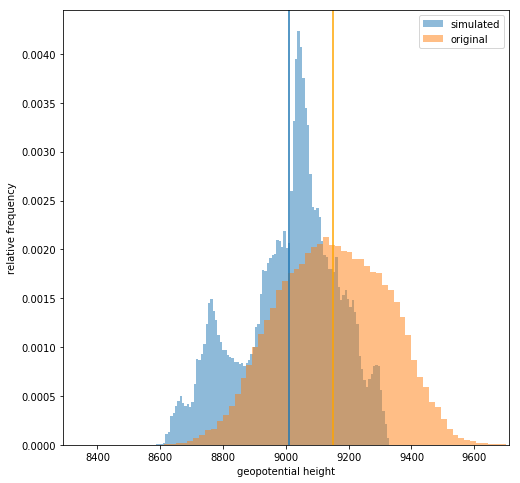

<Figure size 432x288 with 0 Axes>

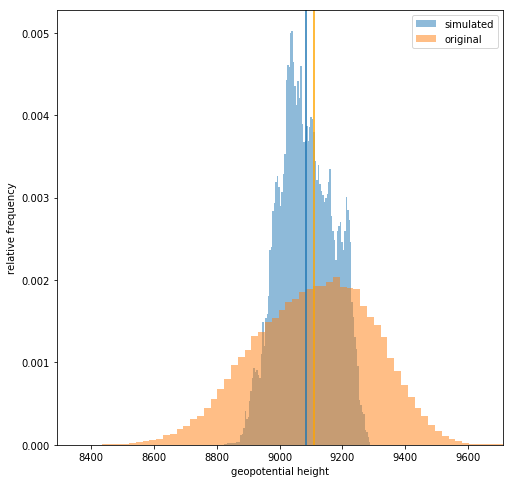

<Figure size 432x288 with 0 Axes>

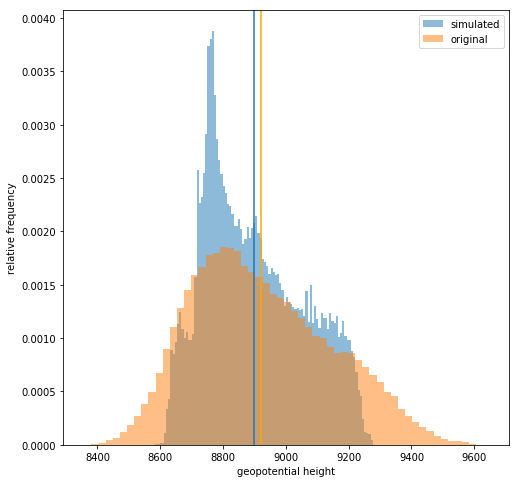

In [27]:
compare_plot(0)

<Figure size 432x288 with 0 Axes>

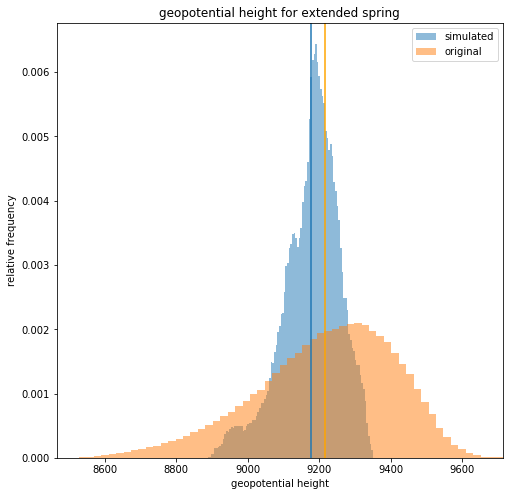

<Figure size 432x288 with 0 Axes>

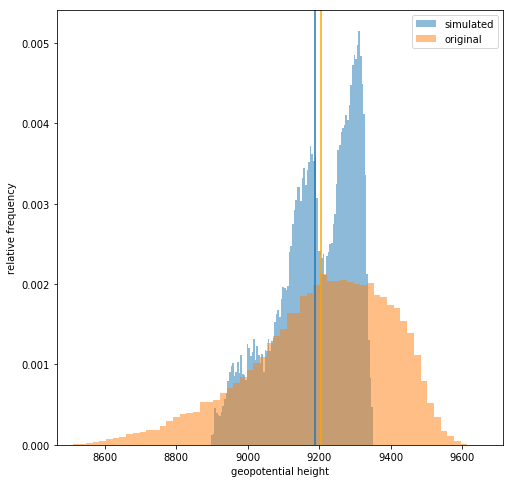

<Figure size 432x288 with 0 Axes>

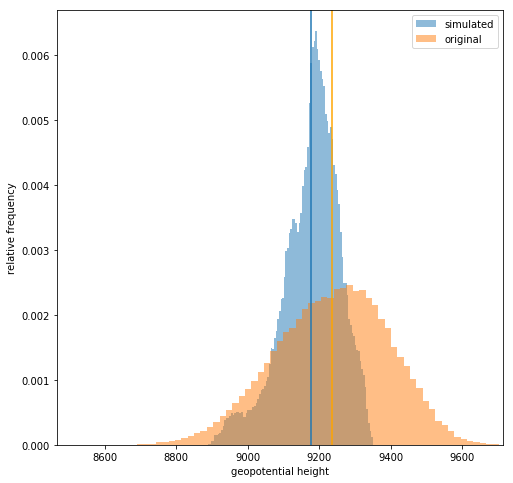

<Figure size 432x288 with 0 Axes>

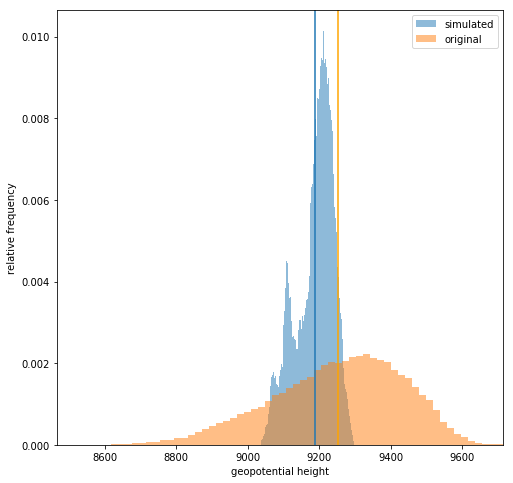

<Figure size 432x288 with 0 Axes>

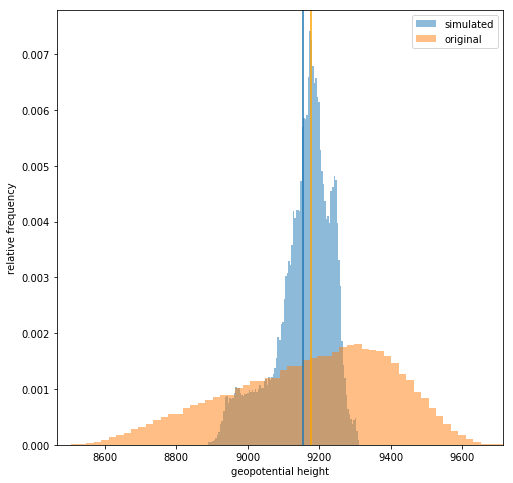

In [28]:
compare_plot(1)

<Figure size 432x288 with 0 Axes>

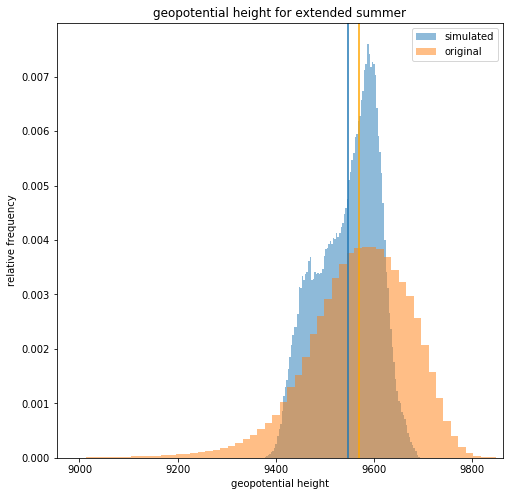

<Figure size 432x288 with 0 Axes>

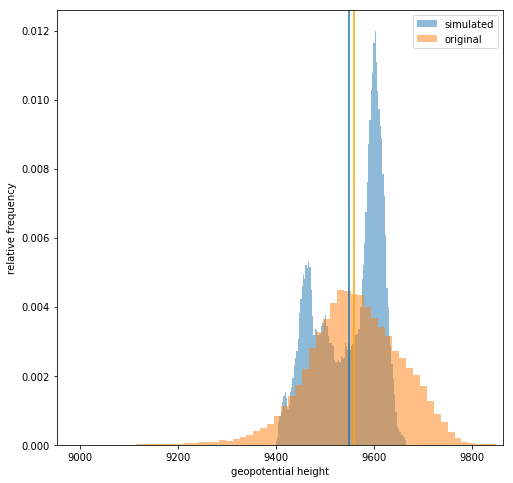

<Figure size 432x288 with 0 Axes>

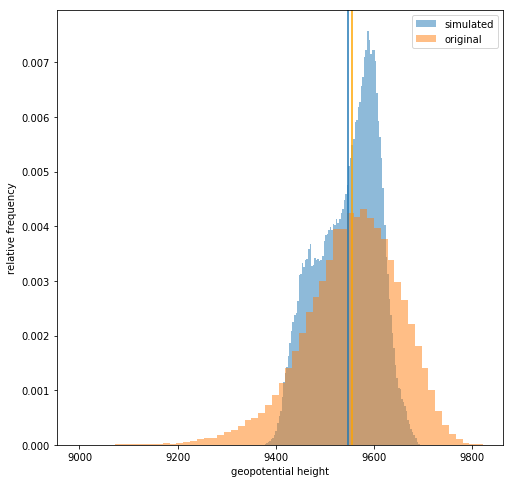

<Figure size 432x288 with 0 Axes>

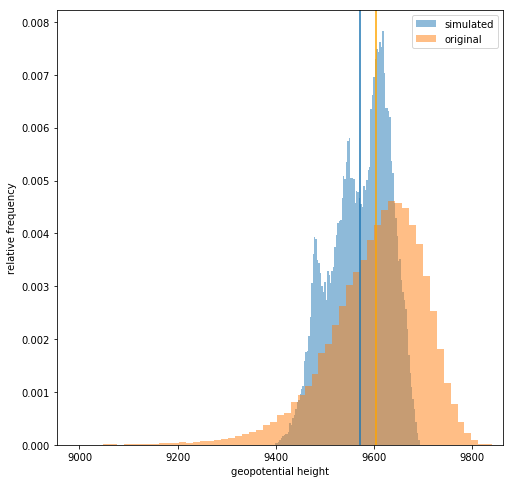

<Figure size 432x288 with 0 Axes>

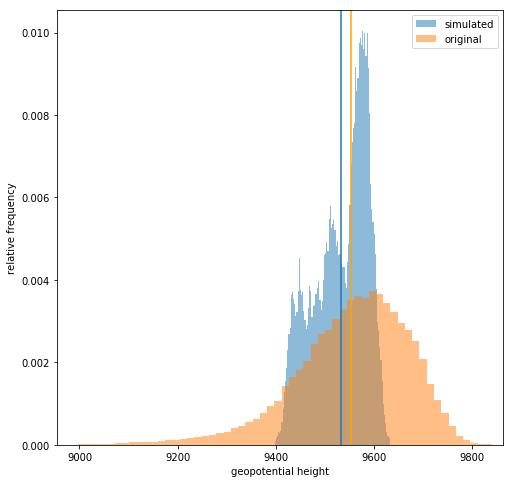

In [29]:
compare_plot(2)

<Figure size 432x288 with 0 Axes>

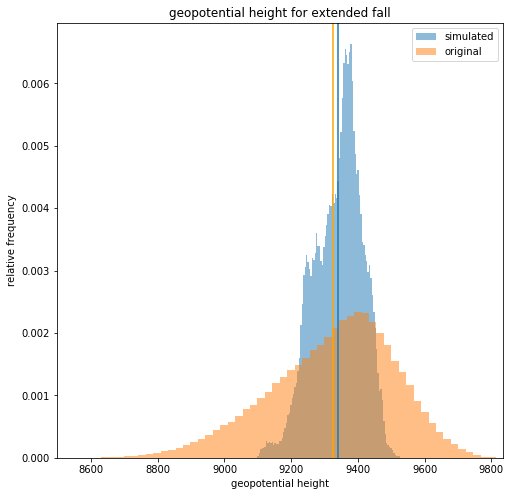

<Figure size 432x288 with 0 Axes>

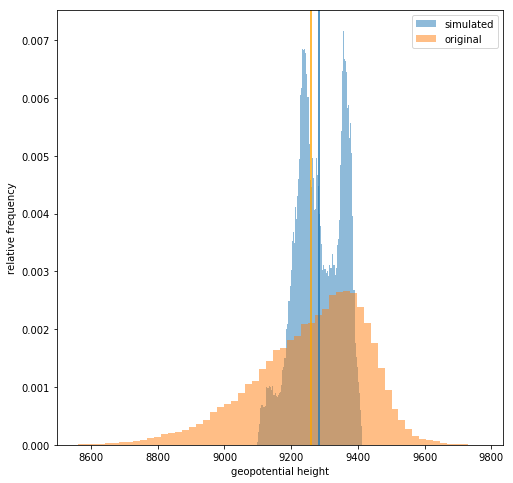

<Figure size 432x288 with 0 Axes>

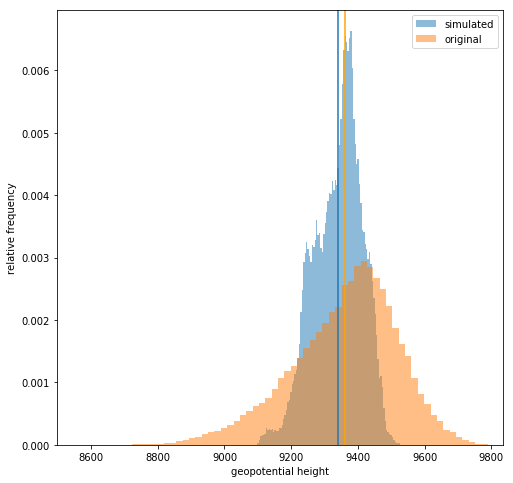

<Figure size 432x288 with 0 Axes>

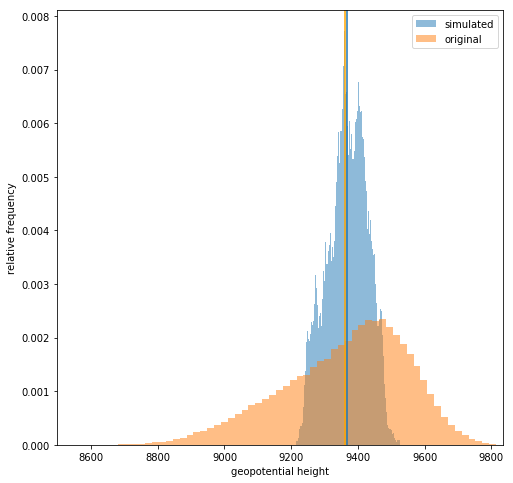

<Figure size 432x288 with 0 Axes>

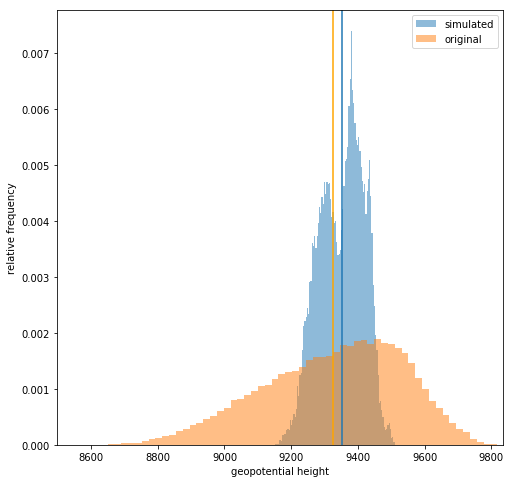

In [30]:
compare_plot(3)

## Now see what the effect of big Gaussian smoothing is?
first recall what the smoothing looks like when we change sigma

<Figure size 432x288 with 0 Axes>

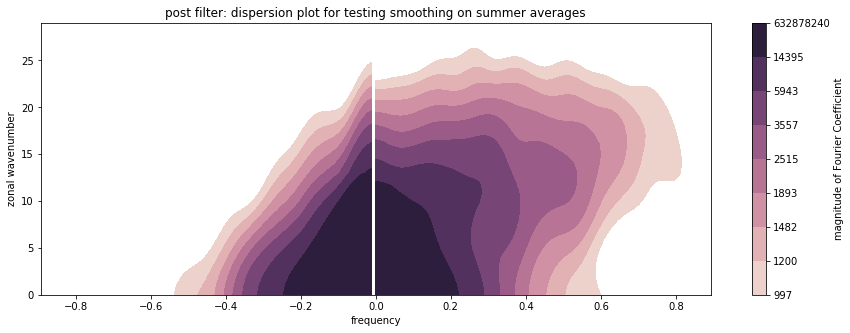

<Figure size 432x288 with 0 Axes>

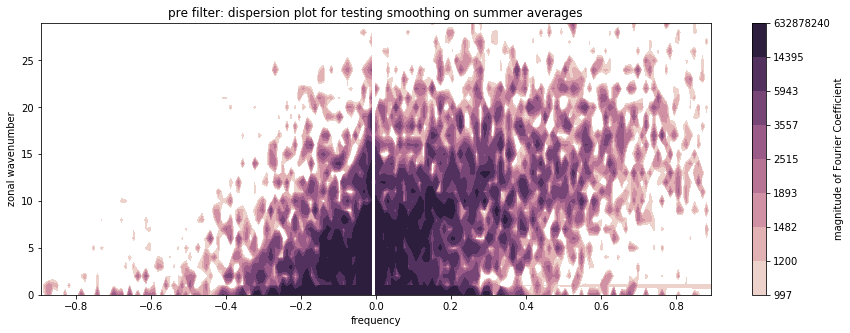

In [31]:
#select a season for plotting
j = 2
test_dat = d2_averages[j]

#set what you wanna crop
max_z = 30
max_f = 0.9

frequencies = fftfreq(372, 0.25)

#crop the data, only keep the positive frequencies
cropped = [[test_dat[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
           for j in range(len(frequencies)) 
           if np.abs(frequencies[j]) < max_f]

cropf = [counted for counted in frequencies if np.abs(counted) < max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(np.real(cropped)))

sigma = 3 # this depends on how noisy your data is, play with it!
testdata = gaussian_filter(Z, sigma)


#set colors and levels for discrete values
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
colors_set = cubehelix_palette(8)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,testdata, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("post filter: dispersion plot for testing smoothing on " + seasons[j] + " averages")
plt.show()

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("pre filter: dispersion plot for testing smoothing on " + seasons[j] + " averages")


plt.show()

### now try to smooth the data and see what the resulting histogram is like

In [32]:
def smooth_season(fftseason, sigma):
    #takes fft array and uses a gaussian to smooth
    #needs to parse both complex and real coeffs separately to use function
    reals = np.real(fftseason)
    ims = np.imag(fftseason)
    
    greals = np.array(gaussian_filter(reals, sigma))
    ims = np.array(gaussian_filter(ims, sigma)*1j)
    
    total = greals + ims
    
    return(total)

#### sigma = 3

In [42]:
#smooth data
sigma = 3
smoothed_seasons = [smooth_season(Z, sigma) for Z in d2_averages]

#apply ifft to smoothed data
extended_smooth = np.real([ext_ifft(length=wantedl, input_array = entry) 
                            for entry in smoothed_seasons])

<Figure size 432x288 with 0 Axes>

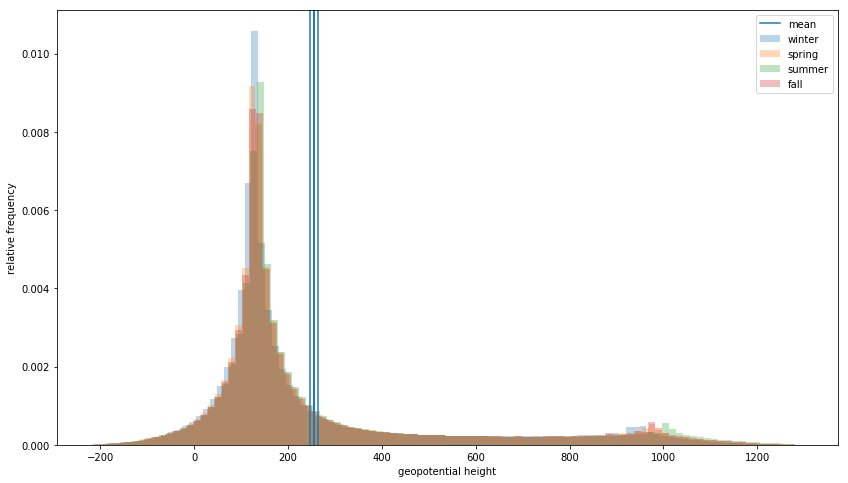

In [43]:
smooth_means = [np.average(entry) for entry in extended_smooth]
#plot histograms!
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    plt.hist(flatten(extended_smooth[i]), label = seasons[i], 
             bins = 100, density = True, alpha = 0.3)
    plt.axvline(smooth_means[i])
plt.xlabel("geopotential height")
plt.axvline(smooth_means[i], label = "mean")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

#### Sigma = 0.3

<Figure size 432x288 with 0 Axes>

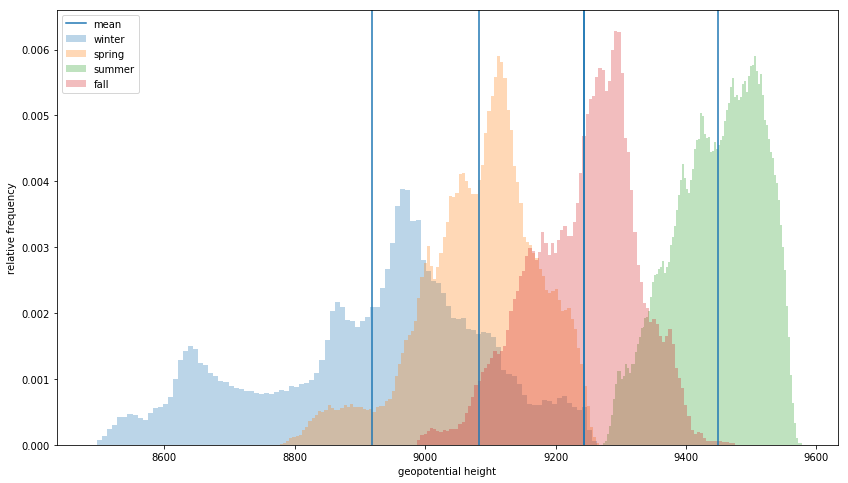

In [35]:
#smooth data
sigma = 0.3
smoothed_seasons = [smooth_season(Z, sigma) for Z in d2_averages]

#apply ifft to smoothed data
extended_smooth = np.real([ext_ifft(length=wantedl, input_array = entry) 
                            for entry in smoothed_seasons])

smooth_means = [np.average(entry) for entry in extended_smooth]
#plot histograms!
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    plt.hist(flatten(extended_smooth[i]), label = seasons[i], 
             bins = 100, density = True, alpha = 0.3)
    plt.axvline(smooth_means[i])
plt.xlabel("geopotential height")
plt.axvline(smooth_means[i], label = "mean")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

#### original histograms

<Figure size 432x288 with 0 Axes>

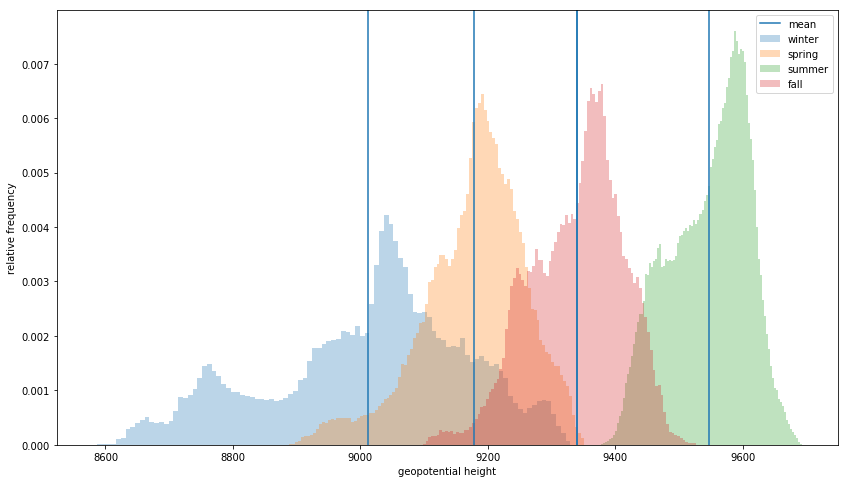

In [36]:
plt.clf();
plt.figure(figsize = (14,8))
for i in range(4):
    plt.hist(flatten(extended_seasons[i]), label = seasons[i], 
             bins = 100, density = True, alpha = 0.3)
    plt.axvline(mean_seasons[i])
plt.xlabel("geopotential height")
plt.axvline(mean_seasons[i], label = "mean")
plt.ylabel("relative frequency")
plt.legend()
plt.show()

### Try Savitzky Golay Filtering

function taken from scipy cookbook (https://scipy-cookbook.readthedocs.io/items/SavitzkyGolay.html)

In [37]:
#!python numbers=enable
def sgolay2d ( z, window_size, order, derivative=None):
    """
    """
    # number of terms in the polynomial expression
    n_terms = ( order + 1 ) * ( order + 2)  / 2.0

    if  window_size % 2 == 0:
        raise ValueError('window_size must be odd')

    if window_size**2 < n_terms:
        raise ValueError('order is too high for the window size')

    half_size = window_size // 2

    # exponents of the polynomial. 
    # p(x,y) = a0 + a1*x + a2*y + a3*x^2 + a4*y^2 + a5*x*y + ... 
    # this line gives a list of two item tuple. Each tuple contains 
    # the exponents of the k-th term. First element of tuple is for x
    # second element for y.
    # Ex. exps = [(0,0), (1,0), (0,1), (2,0), (1,1), (0,2), ...]
    exps = [ (k-n, n) for k in range(order+1) for n in range(k+1) ]

    # coordinates of points
    ind = np.arange(-half_size, half_size+1, dtype=np.float64)
    dx = np.repeat( ind, window_size )
    dy = np.tile( ind, [window_size, 1]).reshape(window_size**2, )

    # build matrix of system of equation
    A = np.empty( (window_size**2, len(exps)) )
    for i, exp in enumerate( exps ):
        A[:,i] = (dx**exp[0]) * (dy**exp[1])

    # pad input array with appropriate values at the four borders
    new_shape = z.shape[0] + 2*half_size, z.shape[1] + 2*half_size
    Z = np.zeros( (new_shape) )
    # top band
    band = z[0, :]
    Z[:half_size, half_size:-half_size] =  band -  np.abs( np.flipud( z[1:half_size+1, :] ) - band )
    # bottom band
    band = z[-1, :]
    Z[-half_size:, half_size:-half_size] = band  + np.abs( np.flipud( z[-half_size-1:-1, :] )  -band )
    # left band
    band = np.tile( z[:,0].reshape(-1,1), [1,half_size])
    Z[half_size:-half_size, :half_size] = band - np.abs( np.fliplr( z[:, 1:half_size+1] ) - band )
    # right band
    band = np.tile( z[:,-1].reshape(-1,1), [1,half_size] )
    Z[half_size:-half_size, -half_size:] =  band + np.abs( np.fliplr( z[:, -half_size-1:-1] ) - band )
    # central band
    Z[half_size:-half_size, half_size:-half_size] = z

    # top left corner
    band = z[0,0]
    Z[:half_size,:half_size] = band - np.abs( np.flipud(np.fliplr(z[1:half_size+1,1:half_size+1]) ) - band )
    # bottom right corner
    band = z[-1,-1]
    Z[-half_size:,-half_size:] = band + np.abs( np.flipud(np.fliplr(z[-half_size-1:-1,-half_size-1:-1]) ) - band )

    # top right corner
    band = Z[half_size,-half_size:]
    Z[:half_size,-half_size:] = band - np.abs( np.flipud(Z[half_size+1:2*half_size+1,-half_size:]) - band )
    # bottom left corner
    band = Z[-half_size:,half_size].reshape(-1,1)
    Z[-half_size:,:half_size] = band - np.abs( np.fliplr(Z[-half_size:, half_size+1:2*half_size+1]) - band )

    # solve system and convolve
    if derivative == None:
        m = np.linalg.pinv(A)[0].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, m, mode='valid')
    elif derivative == 'col':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -c, mode='valid')
    elif derivative == 'row':
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid')
    elif derivative == 'both':
        c = np.linalg.pinv(A)[1].reshape((window_size, -1))
        r = np.linalg.pinv(A)[2].reshape((window_size, -1))
        return scipy.signal.fftconvolve(Z, -r, mode='valid'), scipy.signal.fftconvolve(Z, -c, mode='valid')

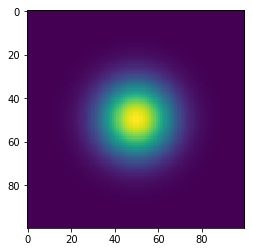

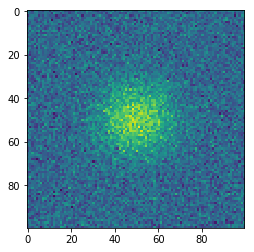

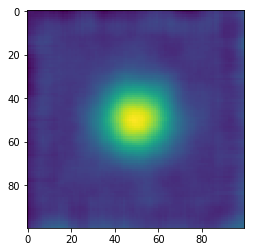

In [38]:
## here is a given test for 2d data
#!python number=enable

# create some sample twoD data
x1 = np.linspace(-3,3,100)
y1 = np.linspace(-3,3,100)
X1, Y1 = np.meshgrid(x1,y1)
Z1 = np.exp( -(X1**2+Y1**2))

# add noise
Zn = Z1 + np.random.normal( 0, 0.2, Z1.shape )

# filter it
Zf = sgolay2d( Zn, window_size=29, order=4)

# do some plotting
plt.clf()
plt.imshow(Z1)
plt.show()
plt.clf()
plt.imshow(Zn)
plt.show()
plt.clf()
plt.imshow(Zf)
plt.show()

<Figure size 432x288 with 0 Axes>

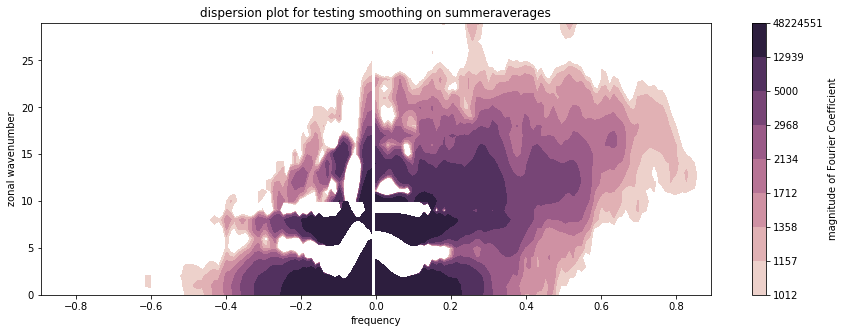

In [39]:
##now test it on my own data
windowlen = 19 # this depends on how noisy your data is, play with it!
testdata = sgolay2d(Z, windowlen, order=7)


#set colors and levels for discrete values
level_set = [np.percentile(testdata, i*5) for i in range(1,21)]
level_set_less = [np.percentile(testdata, i*5) for i in range(1,21) if i*5 >= 60]
colors_set = cubehelix_palette(8)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,testdata, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("dispersion plot for testing smoothing on " + seasons[j] + "averages")


plt.show()

In [40]:
def comp_sgolay2d(fftseason, windowlen, order):
    #takes fft array and uses a gaussian to smooth
    #needs to parse both complex and real coeffs separately to use function
    reals = np.real(fftseason)
    ims = np.imag(fftseason)
    
    greals = np.array(comp_sgolay2d(reals, windowlen, order))
    ims = np.array(comp_sgolay2d(ims, windowlen, order)*1j)
    
    total = greals + ims
    
    return(total)

In [41]:
##now test it on my own data
windowlen = 31 # this depends on how noisy your data is, play with it!
testdata = comp_sgolay2d(test_dat, windowlen, order=3)

RecursionError: maximum recursion depth exceeded

### try loess as well

In [44]:
import statsmodels.api as sm
lowess = sm.nonparametric.lowess

In [65]:
def comp_lowess(entry, frac):
    #needs to parse both complex and real coeffs separately to use function
    reals = np.real(entry)
    ims = np.imag(entry)
    
    greals = np.array(lowess(reals, list(range(len(entry))), frac, return_sorted = False))
    ims = np.array(lowess(ims, list(range(len(entry))), frac, return_sorted = False)*1j)
    
    total = greals + ims
    
    return(total)

In [66]:
lowessed_x = [comp_lowess(entry, frac = 0.1) for entry in test_dat]
touse = np.transpose(lowessed_x)

In [69]:
lowessed_tot = np.transpose([comp_lowess(entry, frac = 0.1) 
                             for entry in touse])

In [70]:
#set what you wanna crop
max_z = 30
max_f = 0.9

frequencies = fftfreq(372, 0.25)

#crop the data, only keep the positive frequencies
cropped = [[lowessed_tot[i][j] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]
           for j in range(len(frequencies)) 
           if np.abs(frequencies[j]) < max_f]

cropf = [counted for counted in frequencies if np.abs(counted) < max_f]# and counted != 0]
cropz = [zonal_spacing[i] for i in range(len(zonal_spacing)) 
            if zonal_spacing[i] < max_z and zonal_spacing[i] >= 0]

x = cropf
y = cropz
X, Y = np.meshgrid(x,y)
X = np.flip(X)
Z = np.transpose(np.abs(np.real(cropped)))

<Figure size 432x288 with 0 Axes>

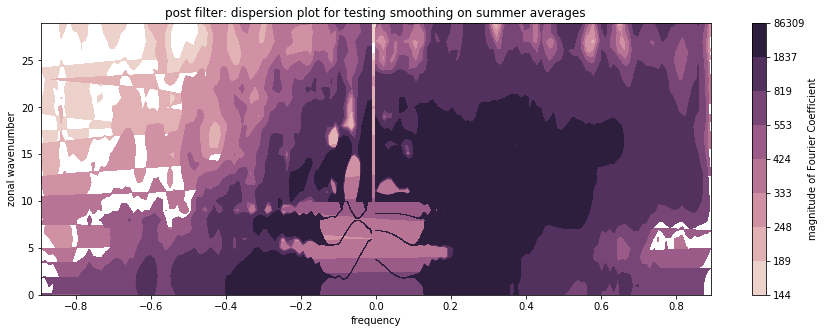

<Figure size 432x288 with 0 Axes>

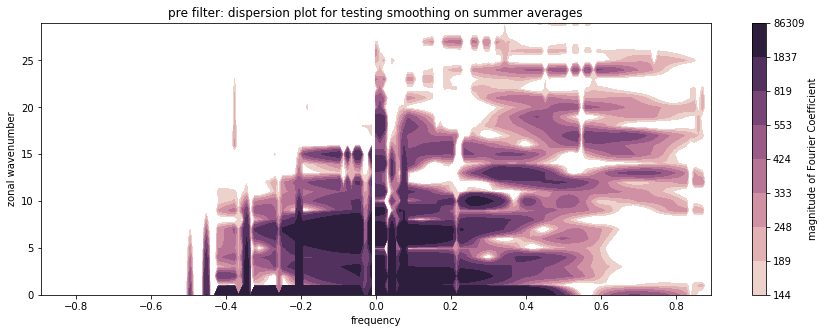

In [71]:
#set colors and levels for discrete values
level_set = [np.percentile(Z, i*5) for i in range(1,21)]
level_set_less = [np.percentile(Z, i*5) for i in range(1,21) if i*5 >= 60]
colors_set = cubehelix_palette(8)

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,testdata, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("post filter: dispersion plot for testing smoothing on " + seasons[j] + " averages")
plt.show()

#plot it
plt.clf();
plt.figure(figsize=(15, 5));

#actual plot
CF = plt.contourf(X,Y,Z, levels = level_set_less, colors = colors_set)

#set colorbars
CBI = plt.colorbar(CF, label = "magnitude of Fourier Coefficient")
labels = [int(entry) for entry in level_set_less]
CBI.set_ticklabels(labels)

#plot labels
plt.xlabel("frequency")
plt.ylabel("zonal wavenumber")
plt.title("pre filter: dispersion plot for testing smoothing on " + seasons[j] + " averages")


plt.show()